## Introduction 

Many optimization problems in scientific research, engineering design and machine learning are black box optimization problems where the objective function $f(\mathbf{x})$ is a black box function. We do not have an analytical expression for $f$ nor do we know its derivatives. Evaluation of the function is restricted to sampling at a point $\mathbf{x}$ and getting a possibly noisy response. 

If $f$ is cheap to evaluate we could sample at many points e.g. via grid search, random search or numeric gradient estimation. However, if function evaluation is expensive e.g. tuning hyperparameters of  a deep neural network, probe drilling for oil at given geographic coordinates or evaluating the effectiveness of a drug candidate taken from a chemical search space, then it is important to minimize the number of samples drawn from the black box function $f$.

Bayesian optimization techniques  attempt to find the global optimimum in a minimum number of steps. Bayesian optimization incorporates prior belief about $f$ and updates the prior with samples drawn from $f$ to get a posterior that better approximates $f$. The model used for approximating the objective function is called a *surrogate model*. Bayesian optimization also uses an *acquisition function* that directs sampling to areas where an improvement over the current best observation is likely.

### Surrogate model

A popular surrogate model for Bayesian optimization are Gaussian processes (GPs). GPs define a prior over functions and we can use them to incorporate prior beliefs about the objective function (smoothness, variability). The GP posterior is cheap to evaluate and is used to propose new points in the search space, where sampling is likely to yield the best improvement. 

### Acquisition functions

Proposing sampling points in the search space is done by an acquisition functions. They trade-off of exploitation and exploration must be considered in the choice of the tuning parameters. The goal being to achieve  high acquisition function values that maximize the acquisition function and in this way determine the next sampling point. 



More formally, the objective function $f$ will be sampled at $\mathbf{x}_t = \mathrm{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$ where $u$ is the acquisition function and $\mathcal{D}_{1:t-1} = \{(\mathbf{x}_1, y_1),...,(\mathbf{x}_{t-1}, y_{t-1})\}$ are the $t-1$ samples drawn from $f$ so far. Popular acquisition functions are *maximum probability of improvement* (PI), *expected improvement* (EI) and *upper confidence bound* (UCB). Here, we will use the expected improvement (EI), which is most widely-used. 

### Optimization algorithm

The Bayesian optimization procedure is as follows. For $t = 1,2,...$ repeat:

- Find the next sampling point $\mathbf{x}_{t}$ by optimizing the acquisition function over the GP: $\mathbf{x}_t = \mathrm{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$
- Obtain a possibly noisy sample $y_t = f(\mathbf{x}_t) + \epsilon_t$ from the objective function $f$.
- Add the sample to previous samples $\mathcal{D}_{1:t} = \{\mathcal{D}_{1:t-1}, (\mathbf{x}_t,y_t)\}$ and update the GP.

### Expected improvement

Expected improvement is defined as

$$\mathrm{EI}(\mathbf{x}) = \mathrm{E}\max(f(\mathbf{x}) - f(\mathbf{x}_*), 0)\tag{1}$$

where $f(\mathbf{x}_*)$ is the value of the best sample so far and $\mathbf{x}_*$ is the location of that sample, i.e. $\mathbf{x}_* = \mathrm{argmax}_{\mathbf{x}_i \in \mathbf{x}_{1:t}} f(\mathbf{x}_i).$ The expected improvement can be evaluated analytically under the GP model, to give

$$
\mathrm{EI}(\mathbf{x}) =
\begin{cases}
(\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi)\Phi(Z) + \sigma(\mathbf{x})\phi(Z)  &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases}\tag{2}
$$

with

$$
Z =
\begin{cases}
\frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi}{\sigma(\mathbf{x})} &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases},
$$

where $\mu(\mathbf{x})$ and $\sigma(\mathbf{x})$ are the mean and the standard deviation of the GP posterior predictive at $\mathbf{x}$, respectively, and $\Phi$ and $\phi$ are the CDF and PDF of the standard normal distribution, respectively. The first summation term in  (2) is the exploitation term and second summation term is the exploration term.

Parameter $\xi$ in Equation (2) determines the amount of exploration during optimization and higher $\xi$ values lead to more exploration. In other words, with increasing $\xi$ values, the importance of improvements predicted by the GP posterior mean $\mu(\mathbf{x})$ decreases relative to the importance of potential improvements in regions of high prediction uncertainty, represented by large $\sigma(\mathbf{x})$ values. A recommended default value for $\xi$ is $0.01$.


## Implementation with NumPy and SciPy

We implement the acquisition function and its optimization in plain NumPy and SciPy and use scikit-learn for the Gaussian process implementation. Although we have an analytical expression of the optimization objective `f,` 
$$ f(x) = \sin 3x - x^2 + 0.7 x,$$

we consider it is as black box and iteratively approximate it with a Gaussian process during Bayesian optimization. Furthermore, samples drawn from the objective function are noisy and the noise level is given by the `noise` variable. Optimization is done within given `bounds`. We also assume that we have two initial data samples in `X_init` and `Y_init`.

Note that, in real cases, the evaluation of $f$ will usually imply the solution of some (costly) system of differential equations, or the execution of some (expensive) experiment. Thus the need for otimal experimental design (OED).

In [1]:
import numpy as np

%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

The following plot shows the noise-free objective function, the amount of noise by plotting a large number of samples and the two initial samples.

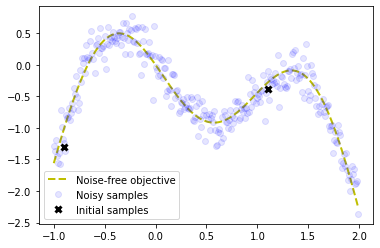

In [2]:
import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bo', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

Our goal is to find the global optimum, on the left, in the smallest number of steps possible. The next step is to implement the acquisition function defined in  (2), as the  `expected_improvement` function. 

In [3]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI is computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z   = imp / sigma
        ei  = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

We also need a function that proposes the next sampling point by computing the maximum of the acquisition function. Optimization is restarted `n_restarts` times to avoid local optima.

In [4]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

Now we have all components needed to run Bayesian optimization with the algorithm outlined above. The Gaussian process in the following example is configured with a Matérn kernel, which is a generalization of the squared exponential kernel or RBF kernel, usually used in GP. The known noise level is configured with the `alpha` parameter. 

Bayesian optimization runs for 10 iterations. In each iteration, a row with two plots is produced. 

- The left plot shows the noise-free objective function, the surrogate function which is the GP posterior predictive mean, the 95% confidence interval of the mean and the noisy samples obtained from the objective function so far. 
- The right plot shows the acquisition function. 
- The vertical dashed line in both plots shows the proposed sampling point for the next iteration, corresponding to the maximum of the acquisition function.

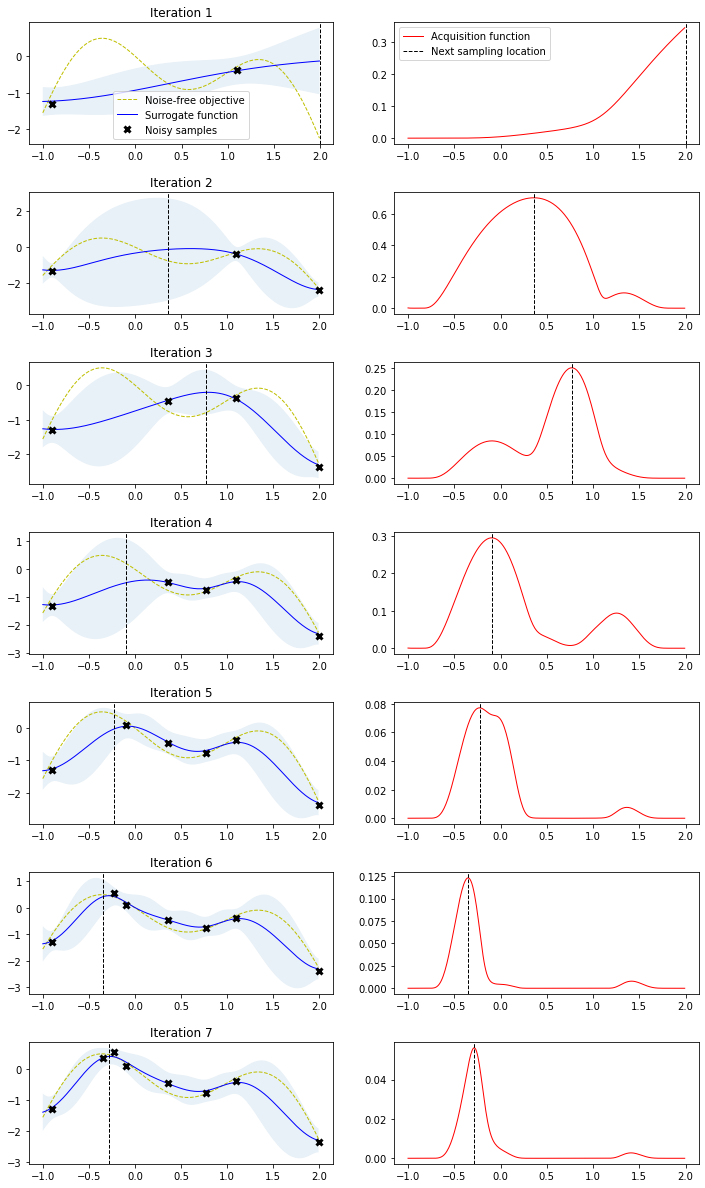

In [7]:
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 7 #10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

Note how the two initial samples initially drive search into the direction of the local maximum on the right side but exploration allows the algorithm to escape from that local optimum and find the global optimum on the left side. Also note how sampling point proposals often fall within regions of high uncertainty (exploration) and are not only driven by the highest surrogate function values (exploitation).

A convergence plot reveals how many iterations are needed the find a maximum and if the sampling point proposals stay around that maximum i.e. converge to small proposal differences between consecutive steps. 

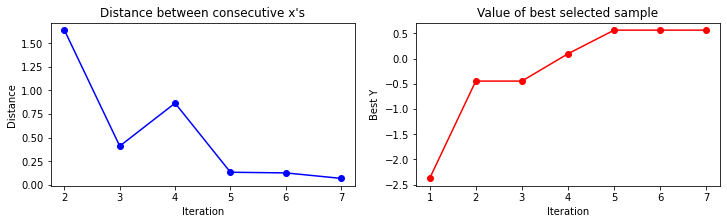

In [8]:
from bayesian_optimization_util import plot_convergence

plot_convergence(X_sample, Y_sample)